# 1. (7pt) Load and clean data

### 1. (1pt) Load and clean data. Feel free to copy-paste from your PS05 solution.

In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

emails = pd.read_csv("../INFO-371/lingspam-emails.csv.bz2", sep="\t")
np.shape(emails)
#pd.set_option("display.max_colwidth", -1) # uncomment to see all the text

df = emails.dropna(subset=["spam", "message"])
df.isna().sum()

spam       0
files      0
message    0
dtype: int64

### 2. (2pt) Vectorize emails so you have a DTM (I’ll refer to this as the design matrix X) and the spam/non-spam indicator y. How many different documents (emails) and different tokens (words) do you have in these data?

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True)
# define vectorizer
X = vectorizer.fit_transform(emails.message)
# vectorize your data. Note: this creates a sparse matrix,
# use .toarray() if you run into trouble
vocabulary = vectorizer.get_feature_names_out()
# in case you want to see what are the actual words

### 3. (2pt) Split data into training/validation chunks.

In [3]:
y = df.spam * 1
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2)

### 4. (2pt) Design a scheme to name your variables so you can understand (and you grader can understand too!) which mathematical concept it refers to.

* P_S1: probability of spam. (Pr(S = 1))
* P_S0: probability of not spam. (Pr(S = 0))
* S0_W: probability the email is not spam given it cointains the word W. (Pr(S = 0|W = 1))
* S1_W: probability the email is spam given it contains the word W. (Pr(S = 1|W = 1))
* W1_S1: probability the word is present, given the email is spam. (Pr(W = 1|S = 1))
* W1_S0: probability the word is present, given the email is non-spam. (Pr(W = 1|S = 0))


* log_W1_S1: log probability that the word is present, given the email is spam. (log Pr(W = 1|S = 1))
* log_W1_S0: log probability that the word is present, given the email is non-spam. (log Pr(W = 1|S = 0))
* log_S1_W: log likelihood of email being spam, given it contains the word W
* log_S0_W: log likelihood of email being non-spam, given it contains the word W
* log_S1_W_sm and log_S0_W_sm: same as the above 2, but with smoothing
* log_S1: log probability of spam (log Pr(S = 1))
* log_S0: log probability of non-spam (log Pr(S = 0))

# 2. (42pt) Naïve Bayes

### 1. (4pt) Here is a small excerpt from the initial DTM (before you split it into training/validation), corresponding to rows 983 to 985, and to columns 40,042–40,046:
```
X[982:985, 40041:40046].toarray()
## array([[0, 0, 0, 0, 0],
##        [0, 1, 0, 1, 0],
##        [0, 0, 0, 0, 0]])
```

### What do these numbers show:
#### (a) which emails do the rows correspond to?

In [4]:
df[982:985]

,spam,files,message
982,False,6-1148msg1.txt,Subject: summary : parsing of ambiguous sequen...
983,False,6-1149msg1.txt,Subject: re : sapir - whorf and what to tell s...
984,False,6-1150msg1.txt,Subject: call for contributions call for cont...


#### (b) Which words do the columns correspond to?

In [5]:
vocabulary[40041:40046]

array(['nooteboom', 'nootka', 'nope', 'nor', 'nora'], dtype=object)

#### (c) What do the “1”-s in the middle of the table mean? 
The 1's in the middle of the table means that the specific word exists in the email.
#### (d) What do the zeros mean?
The 0's means that the specific word does not exist in the email
### Note: you should have exactly the same numbers in your analysis, this is not random.

### 2. (2pt) What is the accuracy of the naive model that predicts all emails into the majority category?

In [6]:
count_reg = y[y == False].shape[0]
print("Number of regular emails: " + str(count_reg))
count_spam = y[y == 1].shape[0]
print("Number of spam emails: " + str(count_spam))

print("Accuracy: " + str(count_reg / (count_spam + count_reg)))
pd.set_option('display.max_rows', None)

Number of regular emails: 2412
Number of spam emails: 481
Accuracy: 0.8337366055997235


### 3. (3pt) Compute the unconditional (log) probability that the email is spam/non-spam, log Pr(S = 1), and log Pr(S = 0). These probabilities are based on the values of y (i.e. spam) alone. They do not contain information about the words in emails.

In [7]:
P_S1 = np.mean(train_y)
P_S0 = 1 - P_S1

log_S1 = np.log(P_S1)
print("log Pr(S = 1):", log_S1)
log_S0 = np.log(P_S0)
print("log Pr(S = 0):", log_S0)

log Pr(S = 1): -1.7678471428525
log Pr(S = 0): -0.18717341174592203


### 4.  For each word w, compute the (log) probability that the word is present in spam emails, log Pr(W = 1|S = 1), and (log) probability that the word is present in non-spam emails, log Pr(W = 1|S = 0). These probabilities can easily be calculated from counts of how many times these words are present for each class.

Hint: these computations are based on your BOW-s X. Look at ways to sum along columns in this matrix.


In [8]:
W1_S1 = train_X[train_y == 1,].mean(axis = 0)
log_W1_S1 = np.log(W1_S1)

W1_S0 = train_X[train_y == 0,].mean(axis = 0)
log_W1_S0 = np.log(W1_S0)

/tmp/ipykernel_310/909295264.py:2: RuntimeWarning: divide by zero encountered in log
  log_W1_S1 = np.log(W1_S1)
/tmp/ipykernel_310/909295264.py:5: RuntimeWarning: divide by zero encountered in log
  log_W1_S0 = np.log(W1_S0)


### 5. What should be the dimension of your log Pr(W = 1|S = 0) and log Pr(W = 1|S = 1) vectors? Explain!


In [9]:
print("log_W1_S1 shape", log_W1_S1.shape, "log_W1_S0 shape", log_W1_S0.shape)

log_W1_S1 shape (1, 60925) log_W1_S0 shape (1, 60925)


Both should have the same shape, and both should also have equal length as the number of unique words in all the emails. This is because we are trying to determine the (log) probability of each word appears in emails that are classified as spam and emails that are classified as non-spam.

### 6. For both classes, S = 1 and S = 0, compute the log-likelihood that the email belongs to this class. Log-likelihood is given as (7.3.20 and 7.3.21, page 270 for now) in lecture notes, and the equations in Schutt “Doing Data Science”, page 102.

#### Computing the likelihoods involves sums of the previously computed probabilities, log Pr(W = 1|S), and BOW elements xij. Start by doing this by whatever way you can get it done (e.g. loops). The most important thing is that you understand what you do!

#### But if you want to write efficient code, use matrix product instead (it is ∼ 1000× faster than loops). See Lecture Notes (7.30.30) for how to do it with matrix product. You can also check out np.apply_along_axis as an alternative way to do it.

In [10]:
log_S1_W = log_S1 + test_X @ np.transpose(log_W1_S1)

log_S0_W = log_S0 + test_X @ np.transpose(log_W1_S0)

log_S1_W.shape, log_S0_W.shape

((579, 1), (579, 1))

### 7. How many log-likelihoods you have to compute? Explain why do you have to have this many log-likelihoods.

We have to compute 2K likelihoods, where K is the amount of emails. Since we are trying to determine whether or not an email is classified as spam or non-spam, we have to compute the probability that it will be spam and non-spam and pick the higher value. So for one email, we have to compute its spam and non-spam probability.

### 8. Based on the log-likelihoods, predict the class S = 1 or S = 0 for each email in the validation set.

In [11]:
compare = (log_S1_W > log_S0_W)

### 9. Print the resulting confusion matrix and accuracy (feel free to use existing libraries).

In [12]:
cm = confusion_matrix(test_y, compare)
print(cm)
print("accuracy:", str(round((cm[0,0]+cm[1,1])/(np.sum(cm)), 2)))

[[493   0]
 [ 75  11]]
accuracy: 0.87


### 10. If your results are like mine, you can see that the results are not impressive at all, your model works no better than the naive guess. Explain why do you get such mediocre results.

#### Hint: this is related to infinites, where are those coming from, and why they make the model useless? See also the smoothing-related discussion in Lecture Notes at the end of the Naive Bayes (Section 7.3.3), before Example 7.3.

#### Note: just explain, but do not do anything about it! We’ll attack the problem in the next question with smoothing. 

Our accuracy was not exactly the same as the naive model, but it is still pretty similar. 

If there is an email that is supposed to be spam, but one of the words in the email has not yet appeared in the spam (ex: Pr(S|W = 0) = 0), this email will never be classified as spam, even though it clearly should be because 0 multiplied by anything will always be 0. For example, if a spam email containing the word 'viagra' appears and Pr(S|viagra = 0) = 0, it will not be classified as spam because 0 multiplied by anything will always be 0. Hence, since we always classify the email class according to the highest probability, it will not be counted as spam, even when it clearly is.

## 3. Add smoothing

### 1. As you will be doing validation below, your first task is to mold what you did above into two functions: one for fitting and another one for predicting. You can mostly copy-paste your code from above.

In [13]:
def fit_data_orig(alpha):
    a = alpha
    P_S1 = np.mean(train_y)
    P_S0 = 1 - P_S1
    log_S1 = np.log10(P_S1)
    log_S0 = np.log10(P_S0)
    
    W1_S1 = train_X[train_y == 1,].mean(axis = 0)
    log_W1_S1 = np.log10(W1_S1)

    W1_S0 = train_X[train_y == 0,].mean(axis = 0)
    log_W1_S0 = np.log10(W1_S0)
    
    log_S1_W = log_S1 + test_X @ np.transpose(log_W1_S1)
    log_S0_W = log_S0 + test_X @ np.transpose(log_W1_S0)
    
    return log_S1_W, log_S0_W
    

def pred_data_orig(log_S1_W, log_S0_W):
    compare = (log_S1_W > log_S0_W)
    cm = confusion_matrix(test_y, compare)
    print(cm)
    print(str(round((cm[0,0]+cm[1,1])/(np.sum(cm)), 2)))


### 2. Add smoothing to the model. Smoothing amounts to assuming that we have “seen” every possible word α ⩾ 0 times already, in both spam and non-spam emails. Note that α does not have to be an integer, and typically the best α < 1.

#### What you have to do is to re-compute the probabilities log Pr(S = 1), log Pr(S = 0), log Pr(W = 1|S = 1), log Pr(W = 1|S = 1), the predictions part will remain unchanged. So you should update your fitting function by adding an additional argument α to it, and modify the probabilities accordingly. (And you use only training data for this.)


In [14]:
def fit_data(alpha):
    a = alpha
    P_S1 = np.mean(train_y)
    P_S0 = 1 - P_S1
    log_S1 = np.log(P_S1)
    log_S0 = np.log(P_S0)

    tot_S1 = (train_X[train_y == 1]).shape[0]
    W1_S1 = (np.sum(train_X[train_y == 1], axis = 0) + alpha)  / (tot_S1 + 2*alpha)
    log_W1_S1 = np.log(W1_S1)

    tot_S0 = (train_X[train_y == 0]).shape[0]
    W1_S0 = (np.sum(train_X[train_y == 0], axis = 0)+ alpha)  / (tot_S0 + 2*alpha)
    log_W1_S0 = np.log(W1_S0)

    log_S1_W = log_S1 + test_X @ np.transpose(log_W1_S1)
    log_S0_W = log_S0 + test_X @ np.transpose(log_W1_S0)

    return log_S1_W, log_S0_W, a
    

def pred_data(log_S1_W, log_S0_W, alpha):
    print("alpha:", alpha)
    compare = (log_S1_W > log_S0_W)
    cm = confusion_matrix(test_y, compare)
    print(cm)
    acc = round((cm[0,0]+cm[1,1])/(np.sum(cm)), 3)
    print("accuracy:", acc)
    return acc


In [15]:
print("Test:")

log_S1_W_sm, log_S0_W_sm, alpha = fit_data(0.2)

pred_data(log_S1_W_sm, log_S0_W_sm, 0.2)

Test:
alpha: 0.2
[[478  15]
 [  1  85]]
accuracy: 0.972


0.972

### 3. Use your updated model for predictions with a few different α-values (on validation data) and report the corresponding confusion matrix and accuracy.

In [16]:
log_S1_W_sm, log_S0_W_sm, alpha = fit_data(0.9)

pred_data(log_S1_W_sm, log_S0_W_sm, alpha)

log_S1_W_sm, log_S0_W_sm, alpha = fit_data(0.5)

pred_data(log_S1_W_sm, log_S0_W_sm, alpha)

log_S1_W_sm, log_S0_W_sm, alpha = fit_data(0.2)

pred_data(log_S1_W_sm, log_S0_W_sm, alpha)

log_S1_W_sm, log_S0_W_sm, alpha = fit_data(0.01)

curr = pred_data(log_S1_W_sm, log_S0_W_sm, alpha)

alpha: 0.9
[[435  58]
 [  0  86]]
accuracy: 0.9
alpha: 0.5
[[466  27]
 [  0  86]]
accuracy: 0.953
alpha: 0.2
[[478  15]
 [  1  85]]
accuracy: 0.972
alpha: 0.01
[[491   2]
 [  2  84]]
accuracy: 0.993


### 4. Use validation to find the best smoothing parameter α. You can just run a loop over different values, but start with very small values (10−8, 10−7, 10−6 up to perhaps 10).

In [17]:
acc = []
for exp in range(1, 10):
    log_S1_W_sm, log_S0_W_sm, alpha = fit_data(10**(-exp))
    acc.append(pred_data(log_S1_W_sm, log_S0_W_sm, alpha))

alpha: 0.1
[[486   7]
 [  2  84]]
accuracy: 0.984
alpha: 0.01
[[491   2]
 [  2  84]]
accuracy: 0.993
alpha: 0.001
[[491   2]
 [  3  83]]
accuracy: 0.991
alpha: 0.0001
[[491   2]
 [  4  82]]
accuracy: 0.99
alpha: 1e-05
[[492   1]
 [  5  81]]
accuracy: 0.99
alpha: 1e-06
[[492   1]
 [  6  80]]
accuracy: 0.988
alpha: 1e-07
[[492   1]
 [  8  78]]
accuracy: 0.984
alpha: 1e-08
[[492   1]
 [  8  78]]
accuracy: 0.984
alpha: 1e-09
[[492   1]
 [  9  77]]
accuracy: 0.983


### 5. Plot how accuracy depends on α. Use log-scale for α

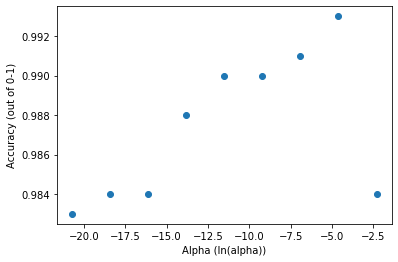

In [23]:
alpha = []
for exp in range(1, 10):
    alpha.append(10**(-exp))
    
plt.scatter(np.log(alpha), acc)
plt.xlabel("Alpha (ln(alpha))")
plt.ylabel("Accuracy (out of 0-1)")
plt.show()

## 4. Interpretation

### 1. Which words are the best predictors that an email is spam? These are the word where Pr(S = 1|W = 1) is large and Pr(S = 0|W = 1) is small, or to put it differently, where log Pr(S = 1|W = 1) − log Pr(S = 0|W = 1) is large.

#### Explain why this is the case.
#### Hint: you may re-check the concept of log-likelihood and how that is used for prediction.
#### Hint 2: you may imagine you receive 60k 1-word emails (one for each word in your vocabulary). Which ones are most likely spam, and which ones are least likely spam?


In [19]:
alpha = 10**(-3)
P_S1 = np.mean(train_y)
P_S0 = 1 - P_S1
log_S1 = np.log(P_S1)
log_S0 = np.log(P_S0)

tot_S1 = (train_X[train_y == 1]).shape[0]
W1_S1 = (np.sum(train_X[train_y == 1], axis = 0) + alpha)  / (tot_S1 + 2*alpha)
log_W1_S1 = np.log(W1_S1)

tot_S0 = (train_X[train_y == 0]).shape[0]
W1_S0 = (np.sum(train_X[train_y == 0], axis = 0)+ alpha)  / (tot_S0 + 2*alpha)
log_W1_S0 = np.log(W1_S0)

test, indx = np.where((log_W1_S1 - log_W1_S0) > 11)

print(vocabulary[indx])

['1302' 'advertiser' 'bonus' 'capitalfm' 'debts' 'earning' 'earnings'
 'fabulous' 'fantastic' 'gambling' 'hottest' 'instant' 'intrusion'
 'lottery' 'mlm' 'mortgage' 'privacy' 'profits' 'relax' 'resell' 'retire'
 'sexually' 'spam' 'stealth' 'unsubscribe']


The words that are the best predictors that an email is spam are listed above. This makes sense because most of these words are those that will not appear often in professional email. For example, words like 'capitalfm', 'hottest', 'mlm', 'paste', 'relax', 'spam', 'stealth', and 'yahoo' are words that you would not expect coming from a professional email. The rest of the words are words that might be used to get the reader's attention quickly. For example, words like 'fantastic' and 'bonus' are words that might trick the reader into opening the email because they might think the email has something that they can gain from. Other words, like 'debt' can be used to instill fear to the reader so that they will open the email as soon as possible.

The reason why we use a large difference between log_W1_S1 and log_W0_S1 is because a good predictor of spam is, not only when the probability of spam is high (and therefore our fitting function would predict it as a spam email), but also when the probability of it being non-spam is low (therefore our fitting function should never predict this as a spam email)). This is especially important, as it prevents words such as "and" that could appear just as frequently in spam and no-spam emails and therefore possibly have very similar probabilites that could change the prediction from no-spam to spam if we had a different dataset that had "and" more frequently in spam emails. The vice versa should be true for words that are ideal predictors for no-spam (i.e, when Pr(S = 0|W = 1) − log Pr(S = 1|W = 1) is large). 

### 2. Find 10 best words to predict spam and 10 best words to predict non-spam. Comment your results.

In [24]:
alpha = 10**(-3)
P_S1 = np.mean(train_y)
P_S0 = 1 - P_S1
log_S1 = np.log(P_S1)
log_S0 = np.log(P_S0)

tot_S1 = (train_X[train_y == 1]).shape[0]
W1_S1 = (np.sum(train_X[train_y == 1], axis = 0) + alpha)  / (tot_S1 + 2*alpha)
log_W1_S1 = np.log(W1_S1)

tot_S0 = (train_X[train_y == 0]).shape[0]
W1_S0 = (np.sum(train_X[train_y == 0], axis = 0)+ alpha)  / (tot_S0 + 2*alpha)
log_W1_S0 = np.log(W1_S0)

list_spam = (log_W1_S1 - log_W1_S0)
list_no_spam = (log_W1_S0 - log_W1_S1)

indx_spam = (-list_spam).argsort()[:,:10]
indx_no_spam = (-list_no_spam).argsort()[:,:10]

print("10 best words to predict spam:", vocabulary[indx_spam])
print("10 best words to predict non-spam:", vocabulary[indx_no_spam])

10 best words to predict spam: [['bonus' 'profits' 'earning' 'mlm' 'fantastic' 'hottest' 'spam' 'resell'
  'unsubscribe' 'relax']]
10 best words to predict non-spam: [['linguistic' 'theory' 'syntax' 'abstract' 'deadline' 'grammar'
  'committee' 'structure' 'abstracts' 'workshop']]
